<a href="https://colab.research.google.com/github/alongstar518/kaggle-steal_defect_classficiation_segementation/blob/master/221_final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CS221 Final Project: Steel Defect Detection 


# To do:
1. Add Data argumentation.


# Routine

### install packages

In [1]:
# No

### Import necessary libraries

In [2]:
import math
import numbers
import io
import os
import pdb
import re
import random
import shutil

from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import cv2

from PIL import Image
from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torch.nn.init
import torch.optim as optim 
import torchvision
import torch.utils.data as utils
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
import torchvision.transforms.functional as vF
from torch.nn import NLLLoss, MultiLabelSoftMarginLoss
import torch.jit
import tensorboard
import torchvision.models as models

from torch import Tensor
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from tensorboard import notebook
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from torch.autograd import Variable
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

/home/zheng/anaconda3/envs/py36/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/zheng/anaconda3/envs/py36/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/zheng/anaconda3/envs/py36/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/zheng/anaconda3/envs/py36/li

### Print torch and cuda information

In [3]:
print("torch version: {}".format(torch.__version__))
print("Cuda device avaliablity: {}".format(torch.cuda.is_available()))
cuda_device_count = torch.cuda.device_count()
if cuda_device_count == 0:
  raise Exception("ERROR: No Cuda Device Avaliable!! Stop!!!!")
print("cuda device count = {}".format(cuda_device_count))
for device_id in range(cuda_device_count):
  print("Cuda device name: {}".format(torch.cuda.get_device_name(device_id)))
  print("Cuda device Capilibility for {}:{}".format(
      device_id,
      torch.cuda.get_device_capability(device=device_id)
    )
  )
  gpu_ram = (
      torch.cuda.get_device_properties(device=device_id).total_memory / (1024) **3
  )
  print(f"GPU{device_id} RAM: {gpu_ram} GB")
  print("===")
#!nvidia-smi

torch version: 1.3.0
Cuda device avaliablity: True
cuda device count = 2
Cuda device name: GeForce RTX 2080
Cuda device Capilibility for 0:(7, 5)
GPU0 RAM: 7.76593017578125 GB
===
Cuda device name: GeForce GTX TITAN X
Cuda device Capilibility for 1:(5, 2)
GPU1 RAM: 11.92529296875 GB
===


# Configs


## basic config:

In [4]:
reload_data = True
clear_tensor_board_history = False
reload_last_model = True
pretrained_backbone = True
data_argumentation = False
ping_pong_argumentation = False
#must_argument = True

inference_mode = False

print_model_summary = False
leave_progress_bar = False
debug = False
multi_gpu = False

pic_resize = False
pic_size = (256, 1600)
rand_crop_size = (256, 256)

backbone_type = "resnet" # or "resnet" or "effnet_b0" or densenet
model_file_name = f"best_{backbone_type}.pth"
# path to local project folder contains the data
path = "/home/zheng/git/cs221_finalproject"
data_path = os.path.join(path, "data")


## data split config

In [5]:
train_data_percent = 0.8
eval_data_percent = 0.1
test_data_percent = 0.1 

##hyperparamters:

In [6]:
batch_size = 2
n_classes = 5
total_epochs = 300
weight_decay=1e-4
lr = 0.01
momentum=0.9
eval_interval = 200

Mode checker

In [7]:
if inference_mode:
  reload_last_model = True

#Data

### download data

In [8]:
try:
  # delay import so we can run on local machine
  # this also check if run it on google drive or not . if it is not, it will 
  # avoiding runing from google colab, but running from local.
  from google.colab import drive
  path = "/content/drive/My Drive/share/"
  remote_data_path = os.path.join(path, "data")
  data_path = "/content/data"
  data_zip_path = os.path.join(
        remote_data_path, "severstal-steel-defect-detection.zip"
      )
  model_save_path = path
  data_zip_path_dst = "/content/severstal-steel-defect-detection.zip"
  os.makedirs(data_path, exist_ok=True)

  if reload_data:
    print("login to google drive")
    drive.mount('/content/drive')
    print("Copy raw data from {} to {}".format(
        data_zip_path, data_zip_path_dst)
    )
    shutil.copy(data_zip_path, "/content")

    print("unzip raw data...")
    os.system("unzip {} -d {}".format(data_zip_path_dst, data_path))
    
    print("give back missing permissions for unzipping")
    os.system(
      "chmod +wrx /content/data/train_images.zip /content/data/test_images.zip"
    )
    
    print("unzipping data...")
    os.system("unzip {} -d {}".format(
        os.path.join(data_path,"train_images.zip"), 
        os.path.join(data_path,"train_images")
        )
    )
    os.system("unzip {} -d {}".format(
        os.path.join(data_path,"test_images.zip"), 
        os.path.join(data_path,"test_images")
      )
    )
    !ls /content/data
except Exception as e:
  print(e)
  print("Running on local machine.")
finally:
  model_save_path = os.path.join(path, model_file_name)


No module named 'google.colab'
Running on local machine.


In [9]:
tr = pd.read_csv(os.path.join(data_path, 'train.csv'))
print(len(tr))
tr.head()

50272


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [10]:
df_train = tr[tr['EncodedPixels'].notnull()].reset_index(drop=True)
if debug:
  df_train = df_train[:100]
#df_train = df_train[df_train['ImageId_ClassId'].apply(lambda x: x.split('_')[1] == '4')].reset_index(drop=True)
print(len(df_train))
df_train.head()

7095


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg_3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg_1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg_4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg_3,229501 11 229741 33 229981 55 230221 77 230468...


In [11]:
def prepare_data(data_frame):
    ret = {}
    for index in range(len(data_frame)):
      fn_array = data_frame['ImageId_ClassId'].iloc[index].split('_')
      fn = fn_array[0]
      category = fn_array[1]
      tmp = ret.get(fn, {})
      tmp.update({category: data_frame['EncodedPixels'].iloc[index]})
      ret[fn] = tmp
    return [{k:v} for k, v in ret.items()]

data_all = prepare_data(df_train)

### data preprocessing function

In [12]:
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )


def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

### Display some sample images

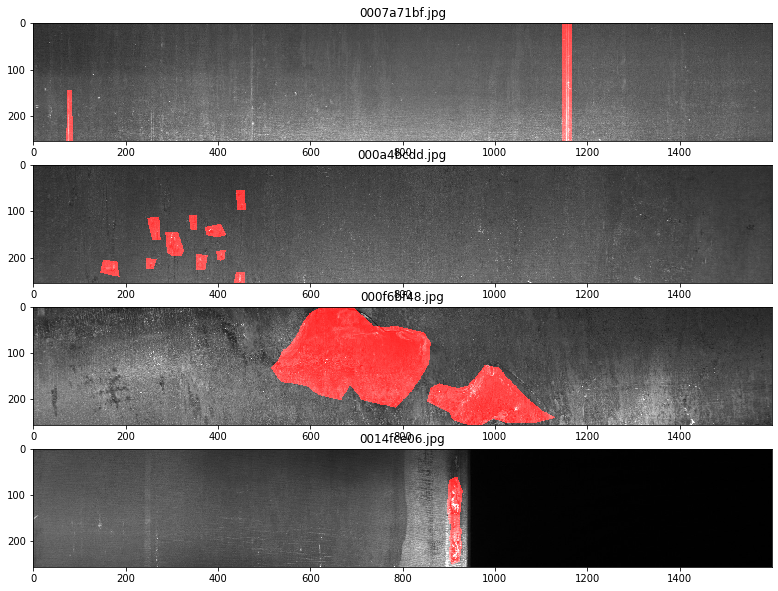

In [13]:
columns = 1
rows = 4
fig = plt.figure(figsize=(20,columns*rows+6))
for i in range(1,columns*rows+1):
    fn = df_train['ImageId_ClassId'].str[:-2].iloc[i]
    fig.add_subplot(rows, columns, i).set_title(fn)
    img = cv2.imread(data_path + '/train_images/'+fn)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle2mask(df_train['EncodedPixels'].iloc[i], (256, 1600))
    img[mask==1,0] = 255
    plt.imshow(img)
plt.show()

### Weighted Random argumentation

In [14]:

def _get_image_size(img):
    if vF._is_pil_image(img):
        return img.size
    elif isinstance(img, torch.Tensor) and img.dim() > 2:
        return img.shape[-2:][::-1]
    else:
        raise TypeError("Unexpected type {}".format(type(img)))

class NoTransform(object):
    def __call__(self, img_x, img_y):
        return img_x, img_y

class RandomCrop(object):
    def __init__(self, size=pic_size[0], padding=None, pad_if_needed=False, fill=0, padding_mode='constant'):
        if isinstance(size, numbers.Number):
            self.size = rand_crop_size#(int(size), int(size))
        else:
            self.size = rand_crop_size#size
        self.padding = padding
        self.pad_if_needed = pad_if_needed
        self.fill = fill
        self.padding_mode = padding_mode

    @staticmethod
    def get_params(img, output_size):
        w, h = _get_image_size(img)
        th, tw = output_size
        if w == tw and h == th:
            return 0, 0, h, w

        i = random.randint(0, h - th)
        j = random.randint(0, w - tw)
        return i, j, th, tw

    def __call__(self, img_x, img_y):
        if self.padding is not None:
            for i, v in enumerate(img_x):
                img_x[i] = vF.pad(v, self.padding, self.fill, self.padding_mode)
            for i, v in enumerate(img_y):
                img_y[i] = vF.pad(v, self.padding, self.fill, self.padding_mode)
        # pad the width if needed
        if self.pad_if_needed and img_x.size[0] < self.size[1]:
            for i, v in enumerate(img_x):
                img_x[i] = vF.pad(v, (self.size[1] - img.size[0], 0), self.fill, self.padding_mode)
            for i, v in enumerate(img_y):
                img_y[i] = vF.pad(v, (self.size[1] - img.size[0], 0), self.fill, self.padding_mode)
        # pad the height if needed
        if self.pad_if_needed and img_x.size[1] < self.size[0]:
            for i, v in enumerate(img_x):
                img_x = vF.pad(img_x, (0, self.size[0] - img.size[1]), self.fill, self.padding_mode)
            for i, v in enumerate(img_y):
                img_y = vF.pad(img_y, (0, self.size[0] - img.size[1]), self.fill, self.padding_mode)
        i, j, h, w = self.get_params(img_x[0], self.size)

        return [vF.crop(x, i, j, h, w) for x in img_x], [vF.crop(y, i, j, h, w) for y in img_y]


class VerticalFlip(object):
    def __call__(self, img_x, img_y):
      if pic_resize:
        for i, v in enumerate(img_x):
            img_x[i] = vF.resize(v, pic_size, interpolation=Image.BILINEAR)
        for i, v in enumerate(img_y):
            img_y[i] = vF.resize(v, pic_size, interpolation=Image.BILINEAR)
      return [vF.vflip(x) for x in img_x], [vF.vflip(y) for y in img_y]


class RandomRotation(object):
    def __init__(self, degrees="rand", resample=False, expand=False, center=None, fill=0):
        if degrees == "rand":
          degrees = random.randint(1, 179)
        if isinstance(degrees, numbers.Number):
            if degrees < 0:
                raise ValueError("If degrees is a single number, it must be positive.")
            self.degrees = (-degrees, degrees)
        else:
            if len(degrees) != 2:
                raise ValueError("If degrees is a sequence, it must be of len 2.")
            self.degrees = degrees

        self.resample = resample
        self.expand = expand
        self.center = center
        self.fill = fill

    @staticmethod
    def get_params(degrees):
        angle = random.uniform(degrees[0], degrees[1])

        return angle

    def __call__(self, img_x, img_y):
        if pic_resize:
          for i, v in enumerate(img_x):
              img_x[i] = vF.resize(v, pic_size, interpolation=Image.BILINEAR)
          for i, v in enumerate(img_y):
              img_y[i] = vF.resize(v, pic_size, interpolation=Image.BILINEAR)
        angle = self.get_params(self.degrees)
        return (
            [vF.rotate(
                x, 
                angle, 
                self.resample, 
                self.expand, 
                self.center, 
            ) for x in img_x],
            [vF.rotate(
                y, 
                angle, 
                self.resample, 
                self.expand, 
                self.center, 
            ) for y in img_y]
        )


argu_transforms = [NoTransform, RandomCrop, VerticalFlip, RandomRotation]
argu_transforms_weight = [0.1, 0.30, 0.30, 0.30]

def get_transform(defect_type=None):
#     will_trans = True
#     if not must_argument:
#         will_trans = np.random.choice(
#             2, 1, data_transform_on_off_weight.get(defect_type)
#         )[0]
  
#     if will_trans:
    return [RandomCrop]#, VerticalFlip, RandomRotation]
    # return np.random.choice(argu_transforms, 1, argu_transforms_weight)[0]
    #return []


### Perform train Dataset argumentation and DataLoader

In [15]:
data_trans = [
      transforms.ToTensor()
    ]
if pic_resize:
  data_trans = [transforms.Resize(pic_size)] + data_trans

data_trans_eval = [transforms.ToTensor()]

data_transf_train = transforms.Compose(data_trans)
data_transf_eval = transforms.Compose(data_trans_eval)

In [16]:
label_color = np.asarray([
                          [0, 0, 0],  #background
                          [128, 0, 0], 
                          [0, 128, 0],
                          [128, 128, 0],
                          [0, 0, 128]
                        ])

def encode_segmap(mask, category):
    label_mask = np.zeros((mask.shape[1], mask.shape[2]), dtype=np.int16)
    label_mask[np.where(np.all(mask > 0, axis=-1))[1:]] = category
    return label_mask

class ImageData(Dataset):
    def __init__(self, data, transform, subset="train"):
        super().__init__()
        self.data = data
        self.transform = transform
        self.subset = subset
        
        if self.subset == "train":
          self.data_path = data_path + "/train_images/"
        elif self.subset == "_test":
          self.data_path = data_path + "/test_images/"
        else:
          self.data_path = data_path + "/train_images/"

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        for key, value in self.data[index].items():
            fn = key
            enc = value
        img = Image.open(self.data_path + fn)
        argu_trans = []
        if self.subset == 'train':
          if data_argumentation:
            argu_trans_class = get_transform(None)
            for argu_class in argu_trans_class:
                argu_trans.append(argu_class())
        
        indexes = []
        masks = []
        for k, v in enc.items():
          tmp_mask = rle2mask(v, (256, 1600))
          tmp_mask = transforms.ToPILImage()(tmp_mask)
          indexes.append(k)
          masks.append(tmp_mask)
        
        img = [img]
        
        for argu in argu_trans:
            img, masks = argu(img, masks)
        
        img = self.transform(img[0])
        
        for i, v in enumerate(masks):
            masks[i] = self.transform(v)
        mask = masks[0].numpy()
        mask[mask > 0] = int(indexes[0])
        
        for i in range(1, len(masks)):
            tmp_mask = masks[i].numpy()
            tmp_mask[tmp_mask > 0] = int(indexes[i])
            mask += tmp_mask
        mask = torch.from_numpy(mask)
        return img, mask

In [17]:
train_indx = int(len(data_all) * train_data_percent)
data_train = data_all[0: train_indx]
eval_indx = int(len(data_all) * eval_data_percent) + train_indx
data_eval = data_all[train_indx: eval_indx]

data_test = data_all[eval_indx:]

train_data = ImageData(data=data_train, transform=data_transf_train, subset="train")
train_loader = DataLoader(
    dataset = train_data, batch_size=batch_size, shuffle=True,
  )

eval_data = ImageData(data=data_eval, transform=data_transf_eval, subset="eval")
eval_loader = DataLoader(dataset = eval_data)

test_data = ImageData(data=data_test, transform=data_transf_eval, subset="test")
test_loader = DataLoader(dataset = test_data)

### Show some image and ground truth (masks)

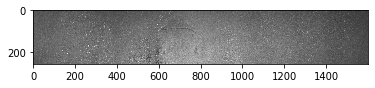

In [18]:
sample_data = train_data[9]
plt.imshow(sample_data[0].permute(1, 2, 0))

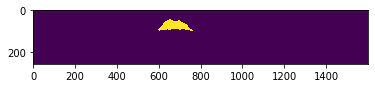

In [19]:
plt.imshow(np.squeeze(sample_data[1].permute(1, 2, 0)))

# Models

##DeeplabV3+


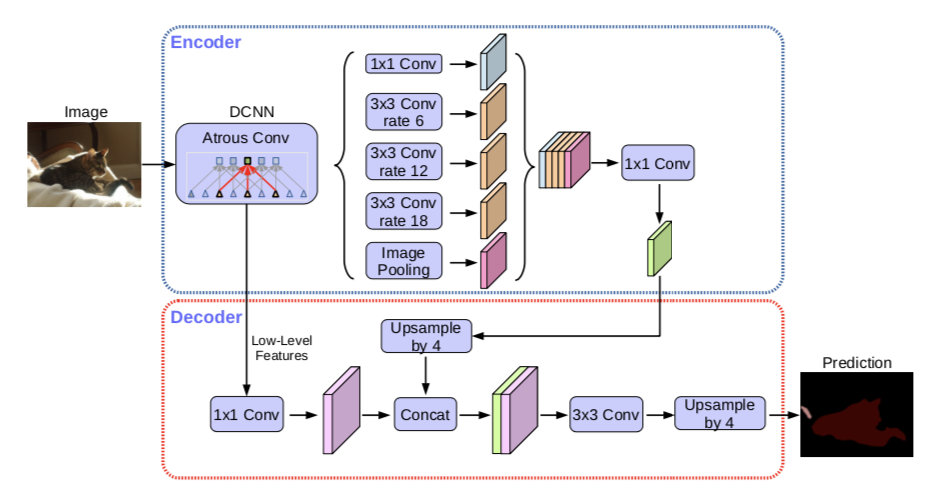

###backbone:  resnet101

In [20]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None, BatchNorm=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               dilation=dilation, padding=dilation, bias=False)
        self.bn2 = BatchNorm(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = BatchNorm(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.dilation = dilation

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, output_stride, BatchNorm, pretrained=True):
        self.inplanes = 64
        super(ResNet, self).__init__()
        blocks = [1, 2, 4]
        if output_stride == 16:
            strides = [1, 2, 2, 1]
            dilations = [1, 1, 1, 2]
        elif output_stride == 8:
            strides = [1, 2, 1, 1]
            dilations = [1, 1, 2, 4]
        else:
            raise NotImplementedError

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                                bias=False)
        self.bn1 = BatchNorm(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0], stride=strides[0], dilation=dilations[0], BatchNorm=BatchNorm)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=strides[1], dilation=dilations[1], BatchNorm=BatchNorm)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=strides[2], dilation=dilations[2], BatchNorm=BatchNorm)
        self.layer4 = self._make_MG_unit(block, 512, blocks=blocks, stride=strides[3], dilation=dilations[3], BatchNorm=BatchNorm)
        self._init_weight()

        if pretrained:
            self._load_pretrained_model()

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1, BatchNorm=None):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, dilation, downsample, BatchNorm))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, dilation=dilation, BatchNorm=BatchNorm))

        return nn.Sequential(*layers)

    def _make_MG_unit(self, block, planes, blocks, stride=1, dilation=1, BatchNorm=None):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, dilation=blocks[0]*dilation,
                            downsample=downsample, BatchNorm=BatchNorm))
        self.inplanes = planes * block.expansion
        for i in range(1, len(blocks)):
            layers.append(block(self.inplanes, planes, stride=1,
                                dilation=blocks[i]*dilation, BatchNorm=BatchNorm))

        return nn.Sequential(*layers)

    def forward(self, input):
        x = self.conv1(input)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        low_level_feat = x
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x, low_level_feat

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _load_pretrained_model(self):
        pretrain_dict = model_zoo.load_url('https://download.pytorch.org/models/resnet101-5d3b4d8f.pth')
        model_dict = {}
        state_dict = self.state_dict()
        for k, v in pretrain_dict.items():
            if k in state_dict:
                model_dict[k] = v
        state_dict.update(model_dict)
        self.load_state_dict(state_dict)

def ResNet101(output_stride, BatchNorm, pretrained=True):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], output_stride, BatchNorm, pretrained=pretrained)
    return model


### backbone: Densenet 201

In [21]:
model_urls = {
    'densenet121': 'https://download.pytorch.org/models/densenet121-a639ec97.pth',
    'densenet169': 'https://download.pytorch.org/models/densenet169-b2777c0a.pth',
    'densenet201': 'https://download.pytorch.org/models/densenet201-c1103571.pth',
    'densenet161': 'https://download.pytorch.org/models/densenet161-8d451a50.pth',
}

class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs):
        # type: (List[Tensor]) -> Tensor
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))
        return bottleneck_output

    # todo: rewrite when torchscript supports any
    def any_requires_grad(self, input):
        # type: (List[Tensor]) -> bool
        for tensor in input:
            if tensor.requires_grad:
                return True
        return False

    @torch.jit.unused  # noqa: T484
    def call_checkpoint_bottleneck(self, input):
        # type: (List[Tensor]) -> Tensor
        def closure(*inputs):
            return self.bn_function(*inputs)

        return cp.checkpoint(closure, input)

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input):
        # type: (List[Tensor]) -> (Tensor)
        pass

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input):
        # type: (Tensor) -> (Tensor)
        pass

    # torchscript does not yet support *args, so we overload method
    # allowing it to take either a List[Tensor] or single Tensor
    def forward(self, input):  # noqa: F811
        if isinstance(input, Tensor):
            prev_features = [input]
        else:
            prev_features = input

        if self.memory_efficient and self.any_requires_grad(prev_features):
            if torch.jit.is_scripting():
                raise Exception("Memory Efficient not supported in JIT")

            bottleneck_output = self.call_checkpoint_bottleneck(prev_features)
        else:
            bottleneck_output = self.bn_function(prev_features)

        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features


class _DenseBlock(nn.Module):
    _version = 2
    __constants__ = ['layers']

    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        self.layers = nn.ModuleDict()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.layers['denselayer%d' % (i + 1)] = layer

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.layers.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)

    @torch.jit.ignore
    def _load_from_state_dict(self, state_dict, prefix, local_metadata, strict,
                              missing_keys, unexpected_keys, error_msgs):
        version = local_metadata.get('version', None)
        if (version is None or version < 2):
            # now we have a new nesting level for torchscript support
            for new_key in self.state_dict().keys():
                # remove prefix "layers."
                old_key = new_key[len("layers."):]
                old_key = prefix + old_key
                new_key = prefix + new_key
                if old_key in state_dict:
                    value = state_dict[old_key]
                    del state_dict[old_key]
                    state_dict[new_key] = value
        super(_DenseBlock, self)._load_from_state_dict(
            state_dict, prefix, local_metadata, strict,
            missing_keys, unexpected_keys, error_msgs)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class DenseNet(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000, memory_efficient=False):

        super(DenseNet, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        low_level_feature = self.features[0](x)
        x = self.features(x)
        return x, low_level_feature


def load_state_dict_from_url(model, model_url):
    pretrain_dict = model_zoo.load_url(model_url)
    return pretrain_dict


def _load_state_dict(model, model_url, progress):
    pattern = re.compile(
        r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')

    state_dict = load_state_dict_from_url(model, model_url)
    for key in list(state_dict.keys()):
        res = pattern.match(key)
        if res:
            new_key = res.group(1) + res.group(2)
            state_dict[new_key] = state_dict[key]
            del state_dict[key]
    model.load_state_dict(state_dict)


def _densenet(arch, growth_rate, block_config, num_init_features, pretrained, progress,
              **kwargs):
    model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)
    if pretrained:
        _load_state_dict(model, model_urls[arch], progress)
    return model


def densenet121(pretrained=False, progress=True, **kwargs):
    return _densenet('densenet121', 32, (6, 12, 24, 16), 64, pretrained, progress,
                     **kwargs)


def densenet161(pretrained=False, progress=True, **kwargs):
    return _densenet('densenet161', 48, (6, 12, 36, 24), 96, pretrained, progress,
                     **kwargs)


def densenet169(pretrained=False, progress=True, **kwargs):
    return _densenet('densenet169', 32, (6, 12, 32, 32), 64, pretrained, progress,
                     **kwargs)


def densenet201(pretrained=False, progress=True, **kwargs):
    return _densenet('densenet201', 32, (6, 12, 48, 32), 64, pretrained, progress,
                     **kwargs)



### backbone: Efficiency Net(prefered model)

In [22]:
model_urls = {
    'efficientnet_b0':
    'https://www.dropbox.com/s/9wigibun8n260qm/efficientnet-b0-4cfa50.pth?dl=1',
    'efficientnet_b1':
    'https://www.dropbox.com/s/6745ear79b1ltkh/efficientnet-b1-ef6aa7.pth?dl=1',
    'efficientnet_b2':
    'https://www.dropbox.com/s/0dhtv1t5wkjg0iy/efficientnet-b2-7c98aa.pth?dl=1',
    'efficientnet_b3':
    'https://www.dropbox.com/s/5uqok5gd33fom5p/efficientnet-b3-bdc7f4.pth?dl=1',
    'efficientnet_b4':
    'https://www.dropbox.com/s/y2nqt750lixs8kc/efficientnet-b4-3e4967.pth?dl=1',
    'efficientnet_b5':
    'https://www.dropbox.com/s/qxonlu3q02v9i47/efficientnet-b5-4c7978.pth?dl=1',
    'efficientnet_b6': None,
    'efficientnet_b7': None,
}

params = {
    'efficientnet_b0': (1.0, 1.0, 224, 0.2),
    'efficientnet_b1': (1.0, 1.1, 240, 0.2),
    'efficientnet_b2': (1.1, 1.2, 260, 0.3),
    'efficientnet_b3': (1.2, 1.4, 300, 0.3),
    'efficientnet_b4': (1.4, 1.8, 380, 0.4),
    'efficientnet_b5': (1.6, 2.2, 456, 0.4),
    'efficientnet_b6': (1.8, 2.6, 528, 0.5),
    'efficientnet_b7': (2.0, 3.1, 600, 0.5),
}


class Swish(nn.Module):

    def __init__(self, *args, **kwargs):
        super(Swish, self).__init__()

    def forward(self, x):
        return x * torch.sigmoid(x)


class ConvBNReLU(nn.Sequential):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, groups=1):
        padding = self._get_padding(kernel_size, stride)
        super(ConvBNReLU, self).__init__(
            nn.ZeroPad2d(padding),
            nn.Conv2d(in_planes,
                      out_planes,
                      kernel_size,
                      stride,
                      padding=0,
                      groups=groups,
                      bias=False),
            nn.BatchNorm2d(out_planes, eps=1e-3, momentum=0.01),
            Swish(),
        )

    def _get_padding(self, kernel_size, stride):
        p = max(kernel_size - stride, 0)
        return [p // 2, p - p // 2, p // 2, p - p // 2]


class SqueezeExcitation(nn.Module):

    def __init__(self, in_planes, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_planes, reduced_dim, 1),
            Swish(),
            nn.Conv2d(reduced_dim, in_planes, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)


class MBConvBlock(nn.Module):

    def __init__(self,
                 in_planes,
                 out_planes,
                 expand_ratio,
                 kernel_size,
                 stride,
                 reduction_ratio=4,
                 drop_connect_rate=0.2,
                 BatchNorm=nn.BatchNorm2d):
        super(MBConvBlock, self).__init__()
        self.drop_connect_rate = drop_connect_rate
        self.use_residual = in_planes == out_planes and stride == 1
        assert stride in [1, 2]
        assert kernel_size in [3, 5]

        hidden_dim = in_planes * expand_ratio
        reduced_dim = max(1, int(in_planes / reduction_ratio))

        layers = []
        # pw
        if in_planes != hidden_dim:
            layers += [ConvBNReLU(in_planes, hidden_dim, 1)]

        layers += [
            # dw
            ConvBNReLU(hidden_dim,
                       hidden_dim,
                       kernel_size,
                       stride=stride,
                       groups=hidden_dim),
            # se
            SqueezeExcitation(hidden_dim, reduced_dim),
            # pw-linear
            nn.Conv2d(hidden_dim, out_planes, 1, bias=False),
            BatchNorm(out_planes, eps=1e-3, momentum=0.01),
        ]

        self.conv = nn.Sequential(*layers)

    def _drop_connect(self, x):
        if not self.training:
            return x
        keep_prob = 1.0 - self.drop_connect_rate
        batch_size = x.size(0)
        random_tensor = keep_prob
        random_tensor += torch.rand(batch_size, 1, 1, 1, device=x.device)
        binary_tensor = random_tensor.floor()
        return x.div(keep_prob) * binary_tensor

    def forward(self, x):
        if self.use_residual:
            return x + self._drop_connect(self.conv(x))
        else:
            return self.conv(x)


def _make_divisible(value, divisor=8):
    new_value = max(divisor, int(value + divisor / 2) // divisor * divisor)
    if new_value < 0.9 * value:
        new_value += divisor
    return new_value


def _round_filters(filters, width_mult):
    if width_mult == 1.0:
        return filters
    return int(_make_divisible(filters * width_mult))


def _round_repeats(repeats, depth_mult):
    if depth_mult == 1.0:
        return repeats
    return int(math.ceil(depth_mult * repeats))


class EfficientNet(nn.Module):

    def __init__(self,
                 width_mult=1.0,
                 depth_mult=1.0,
                 dropout_rate=0.2,
                 num_classes=1000,
                 pooling_mode='mean',
                 classifier='linear',
                 BatchNorm=nn.BatchNorm2d):
        super(EfficientNet, self).__init__()

        # yapf: disable
        settings = [
            # t,  c, n, s, k
            [1, 16, 1, 1, 3],  # MBConv1_3x3, SE, 112 -> 112
            [6, 24, 2, 2, 3],  # MBConv6_3x3, SE, 112 ->  56
            [6, 40, 2, 2, 5],  # MBConv6_5x5, SE,  56 ->  28
            [6, 80, 3, 2, 3],  # MBConv6_3x3, SE,  28 ->  14
            [6, 112, 3, 1, 5],  # MBConv6_5x5, SE,  14 ->  14
            [6, 192, 4, 2, 5],  # MBConv6_5x5, SE,  14 ->   7
            [6, 320, 1, 1, 3]   # MBConv6_3x3, SE,   7 ->   7
        ]
        # yapf: enable

        out_channels = _round_filters(32, width_mult)
        features = [ConvBNReLU(3, out_channels, 3, stride=2)]

        in_channels = out_channels
        for t, c, n, s, k in settings:
            out_channels = _round_filters(c, width_mult)
            repeats = _round_repeats(n, depth_mult)
            for i in range(repeats):
                stride = s if i == 0 else 1
                features += [MBConvBlock(in_channels,
                                         out_channels,
                                         expand_ratio=t,
                                         stride=stride,
                                         kernel_size=k,
                                         BatchNorm=BatchNorm)]
                in_channels = out_channels

        last_channels = _round_filters(1280, width_mult)
        features += [ConvBNReLU(in_channels, last_channels, 1)]
        self.features = nn.Sequential(*features)

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                fan_out = m.weight.size(0)
                init_range = 1.0 / math.sqrt(fan_out)
                nn.init.uniform_(m.weight, -init_range, init_range)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        low_level_layer = 6
        low_level_feat = self.features[:low_level_layer](x)
        x = self.features[low_level_layer:](low_level_feat)
        return x, low_level_feat


def _efficientnet(arch, pretrained, progress, **kwargs):
    width_mult, depth_mult, _, dropout_rate = params[arch]
    model = EfficientNet(width_mult, depth_mult, dropout_rate, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model, model_urls[arch])

        if 'num_classes' in kwargs and kwargs['num_classes'] != 1000:
            del state_dict['classifier.1.weight']
            del state_dict['classifier.1.bias']

        model.load_state_dict(state_dict, strict=False)
    return model


def efficientnet_b0(pretrained=False, progress=True, **kwargs):
    return _efficientnet('efficientnet_b0', pretrained, progress, **kwargs)


def efficientnet_b1(pretrained=False, progress=True, **kwargs):
    return _efficientnet('efficientnet_b1', pretrained, progress, **kwargs)


def efficientnet_b2(pretrained=False, progress=True, **kwargs):
    return _efficientnet('efficientnet_b2', pretrained, progress, **kwargs)


def efficientnet_b3(pretrained=False, progress=True, **kwargs):
    return _efficientnet('efficientnet_b3', pretrained, progress, **kwargs)


def efficientnet_b4(pretrained=False, progress=True, **kwargs):
    return _efficientnet('efficientnet_b4', pretrained, progress, **kwargs)


def efficientnet_b5(pretrained=False, progress=True, **kwargs):
    return _efficientnet('efficientnet_b5', pretrained, progress, **kwargs)


def efficientnet_b6(pretrained=False, progress=True, **kwargs):
    return _efficientnet('efficientnet_b6', pretrained, progress, **kwargs)


def efficientnet_b7(pretrained=False, progress=True, **kwargs):
    return _efficientnet('efficientnet_b7', pretrained, progress, **kwargs)


In [23]:
def build_backbone(backbone, output_stride, BatchNorm, model_type="resnet"):
  if model_type == "resnet":
    return ResNet101(output_stride, BatchNorm, pretrained=pretrained_backbone)
  elif model_type == "densenet":
    return densenet201(pretrained=pretrained_backbone)
  elif model_type == "effnet_b0":
    return efficientnet_b0(pretrained=pretrained_backbone)
  elif model_type == "effnet_b1":
    return efficientnet_b1(pretrained=pretrained_backbone)
  elif model_type == "effnet_b5":
    return efficientnet_b5(pretrained=pretrained_backbone)

###ASPP

In [24]:
class _ASPPModule(nn.Module):
    def __init__(self, inplanes, planes, kernel_size, padding, dilation, BatchNorm):
        super(_ASPPModule, self).__init__()
        self.atrous_conv = nn.Conv2d(inplanes, planes, kernel_size=kernel_size,
                                            stride=1, padding=padding, dilation=dilation, bias=False)
        self.bn = BatchNorm(planes)
        self.relu = nn.ReLU()

        self._init_weight()

    def forward(self, x):
        x = self.atrous_conv(x)
        x = self.bn(x)

        return self.relu(x)

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

class ASPP(nn.Module):
    def __init__(self, backbone, output_stride, BatchNorm):
        super(ASPP, self).__init__()
        if backbone_type == "resnet":
          inplanes = 2048
        elif backbone_type == "densenet":
          inplanes = 1920
        elif backbone_type == "effnet_b0":
          inplanes = 1280
        elif backbone_type == "effnet_b1":
          inplanes = 1280
        elif backbone_type == "effnet_b5":
          inplanes = 2048
        if output_stride == 16:
            dilations = [1, 6, 12, 18]
        elif output_stride == 8:
            dilations = [1, 12, 24, 36]
        else:
            raise NotImplementedError

        self.aspp1 = _ASPPModule(inplanes, 256, 1, padding=0, dilation=dilations[0], BatchNorm=BatchNorm)
        self.aspp2 = _ASPPModule(inplanes, 256, 3, padding=dilations[1], dilation=dilations[1], BatchNorm=BatchNorm)
        self.aspp3 = _ASPPModule(inplanes, 256, 3, padding=dilations[2], dilation=dilations[2], BatchNorm=BatchNorm)
        self.aspp4 = _ASPPModule(inplanes, 256, 3, padding=dilations[3], dilation=dilations[3], BatchNorm=BatchNorm)

        self.global_avg_pool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                             nn.Conv2d(inplanes, 256, 1, stride=1, bias=False),
                                             BatchNorm(256),
                                             nn.ReLU())
        self.conv1 = nn.Conv2d(1280, 256, 1, bias=False)
        self.bn1 = BatchNorm(256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self._init_weight()

    def forward(self, x):
        x1 = self.aspp1(x)
        x2 = self.aspp2(x)
        x3 = self.aspp3(x)
        x4 = self.aspp4(x)
        x5 = self.global_avg_pool(x)
        x5 = F.interpolate(x5, size=x4.size()[2:], mode='bilinear', align_corners=True)
        x = torch.cat((x1, x2, x3, x4, x5), dim=1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        return self.dropout(x)

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
def build_aspp(backbone, output_stride, BatchNorm):
    return ASPP(backbone, output_stride, BatchNorm)

###Decoder

In [25]:
class Decoder(nn.Module):
    def __init__(self, num_classes, backbone, BatchNorm):
        super(Decoder, self).__init__()
        bn1_norm = 48
        last_conv_inplanes = 304
        if backbone_type == "resnet":
          low_level_inplanes = 256
          low_level_out = 48
        elif backbone_type == "densenet":
          low_level_inplanes = 64
          low_level_out = 48
        elif backbone_type == "effnet_b0":
          low_level_inplanes = 40
          low_level_out = 40
          bn1_norm = 40
          last_conv_inplanes = 296
        elif backbone_type == "effnet_b1":
          low_level_inplanes = 24
          low_level_out = 24
          bn1_norm = 24
          last_conv_inplanes = 280
        elif backbone_type == "effnet_b5":
          low_level_inplanes = 24
          low_level_out = 40
          bn1_norm = 40
          last_conv_inplanes = 296
        self.conv1 = nn.Conv2d(low_level_inplanes, low_level_out, 1, bias=False)
        self.bn1 = BatchNorm(bn1_norm)
        self.relu = nn.ReLU()
        self.last_conv = nn.Sequential(nn.Conv2d(last_conv_inplanes, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                       BatchNorm(256),
                                       nn.ReLU(),
                                       nn.Dropout(0.5),
                                       nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                       BatchNorm(256),
                                       nn.ReLU(),
                                       nn.Dropout(0.1),
                                       nn.Conv2d(256, num_classes, kernel_size=1, stride=1))
        self._init_weight()
        

    def forward(self, x, low_level_feat):
        low_level_feat = self.conv1(low_level_feat)
        low_level_feat = self.bn1(low_level_feat)
        low_level_feat = self.relu(low_level_feat)
        x = F.interpolate(x, size=low_level_feat.size()[2:], mode='bilinear', align_corners=True) 
        x = torch.cat((x, low_level_feat), dim=1)
        x = self.last_conv(x)

        return x

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


def build_decoder(num_classes, backbone, BatchNorm):
    return Decoder(num_classes, backbone, BatchNorm)

###deeplab

In [26]:
class DeepLab(nn.Module):
    def __init__(self, backbone='resnet', output_stride=16, num_classes=n_classes,
                 sync_bn=True, freeze_bn=False):
        super(DeepLab, self).__init__()
        BatchNorm = nn.BatchNorm2d

        self.backbone = build_backbone(backbone, output_stride, BatchNorm, model_type=backbone_type)
        self.aspp = build_aspp(backbone, output_stride, BatchNorm)
        self.decoder = build_decoder(num_classes, backbone, BatchNorm)
        self.upchannel = nn.Conv2d(256, 2048, 3)
        self.bn = BatchNorm(2048)
        self.relu = nn.ReLU()
        
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
        #                         bias=False)
        # self.bn1 = BatchNorm(64)
        # self.relu1 = nn.ReLU(inplace=True)
        # self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        if freeze_bn:
            self.freeze_bn()

    def forward(self, input):
        # low_level_feat = self.conv1(input)
        # low_level_feat = self.bn1(low_level_feat)
        # low_level_feat = self.relu1(low_level_feat)
        # low_level_feat = self.maxpool1(low_level_feat)
        x, low_level_feat = self.backbone(input)
        x = self.aspp(x)
        x = self.decoder(x, low_level_feat)
        x = F.interpolate(x, size=input.size()[2:], mode='bilinear', align_corners=True)

        return x

    def freeze_bn(self):
        for m in self.modules():
            if isinstance(m, SynchronizedBatchNorm2d):
                m.eval()
            elif isinstance(m, nn.BatchNorm2d):
                m.eval()

# Train

## Define loss

In [27]:
class SegmentationLosses(object):
    def __init__(self, 
                 weight=None, 
                 size_average=True, 
                 batch_average=True, 
                 ignore_index=255, 
                 cuda=False):
        self.ignore_index = ignore_index
        self.weight = weight
        self.size_average = size_average
        self.batch_average = batch_average
        self.cuda = cuda

    def build_loss(self):
        return self.CrossEntropyLoss

    def CrossEntropyLoss(self, logit, target):
        n, c, h, w = logit.size()
        criterion = nn.CrossEntropyLoss(weight=self.weight, 
                                        ignore_index=self.ignore_index,
                                        reduction='mean')
        if self.cuda:
            criterion = criterion.cuda()

        loss = criterion(logit, target.long())

        if self.batch_average:
            loss /= n

        return loss

## Init for training

In [28]:
last_result = 0
last_result_acc = 0
starting_epoch = 0
total_it = 0
model = DeepLab().cuda()
if cuda_device_count > 1 and multi_gpu:
  model = nn.DataParallel(model)
if print_model_summary:
  summary(model, (3, 256, 256))
optimizer = torch.optim.SGD(
    model.parameters(), weight_decay=weight_decay, lr = lr, momentum=momentum
)
scheduler = ReduceLROnPlateau(optimizer, "min")
if reload_last_model and os.path.exists(model_save_path):
  print("Loading model from {}".format(model_save_path))
  state = torch.load(model_save_path)
  last_result = state.get("last_best", 0)
  last_result_acc = state.get("last_best_acc", 0)
  starting_epoch = state.get("epoch", 0)
  model.load_state_dict(state.get("model_state_dict"))
  if "optimizer_state_dict" in state:
    optimizer.load_state_dict(state.get("optimizer_state_dict"))
  
  if "total_iterations" in state:
    total_it = state.get("total_iterations")
else:
  print("Not load model, train from scrath")
criterion = SegmentationLosses(batch_average=False).build_loss()


Not load model, train from scrath


## define training eval and test functions

Get LR value if we use lr decay

In [29]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

Eval Matrics:

In [30]:
SMOOTH = 1e-6

def dice_coefficient(x, y):
  """
  :param X: numpy array
  :param y: numpy array
  :return: float, dice coefficient for one x, y pair
  x, y is mask the preidiction values (mask)
  """
  x = x.squeeze()
  #y = y.squeeze()
  return 2. * np.count_nonzero((x > 0) & (y > 0)) / (np.count_nonzero(x > 0) + np.count_nonzero(y > 0))


def iou_numpy(outputs, labels: np.array):
    outputs = outputs.squeeze()
    if isinstance(outputs, torch.Tensor):
      outputs = outputs.numpy()
    intersection = ((outputs > 0) & (labels > 0)).sum()
    union = ((outputs > 0) | (labels > 0)).sum()
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
  
    return iou

def accuracy_numpy(outputs, labels):
    acc = accuracy_with_margin_numpy(outputs, labels, 0)
    return acc

def accuracy_with_margin_numpy(outputs, labels, margin=0):
    correct = 0
    for i, mask in enumerate(outputs):
      out_label = []
      true_label = []
      label = labels[i]
      if isinstance(mask, torch.Tensor):
        mask = mask.numpy()
      if isinstance(label, torch.Tensor):
        label = label.numpy()
        
      for i in range(1, 5):
        if np.sum(mask == i) > 0:
            out_label.append(i)
        
        if np.sum(label == i) > 0:
            true_label.append(i)
      
      true_label.sort()
      mask.sort()
      
      if true_label == mask_label:
        correct += 1
    acc = correct / len(labels)
    return acc


Inference:

In [31]:
def decode_seg_map_sequence(label_masks):
    rgb_masks = []
    for label_mask in label_masks:
        rgb_mask = decode_segmap(label_mask)
        rgb_masks.append(rgb_mask)
    rgb_masks = torch.from_numpy(np.array(rgb_masks).transpose([0, 3, 1, 2]))
    return rgb_masks


def decode_segmap(label_mask, plot=False):    
    r = label_mask.copy()
    g = label_mask.copy()
    b = label_mask.copy()
    t = label_mask.copy()
    for c in range(n_classes):
      r[t == c] = label_color[c, 0]
      g[t == c] = label_color[c, 1]
      b[t == c] = label_color[c, 2]
    rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    if plot:
        plt.imshow(rgb)
        plt.show()
    
    return rgb


def predict(model, data_loader, resize=False, out_mask=True):
    predict = []
    Y = []
    raw = []
    model.eval() 
    print("Predicting...")
    total = 0
    losses = []
    print_out = False
    torch.set_printoptions(profile="full")
    with tqdm_notebook(total=len(data_loader.dataset), leave=leave_progress_bar) as pbar:
      for data, y in data_loader:
        with torch.no_grad():
          o = model(data.cuda())  
        o = o.cpu().detach()
        loss = criterion(o, y.squeeze(1))
        losses.append(loss)
        pred = o.numpy()
        pred = np.argmax(pred, axis=1)
        
        if print_out:
          print(pred)
          print_out = False

        predict.append(pred.squeeze(0))
        raw.append(data)
        Y.append(y)

        pbar.update(1)
    predict_loss = np.average(losses)
    print(f"Predict Loss = {predict_loss}")
    return predict, Y, raw, predict_loss


Eval Data:

In [32]:
def eval_data_set(model, data_loader, matrics):
  corr = []
  predictions, Y, raw, loss = predict(model, data_loader)
  for i, mask in enumerate(predictions):
    corr.append(matrics(mask, Y[i].numpy()))
  
  acc = accuracy_numpy(predictions, Y)
  acc_adj = accuracy_with_margin_numpy(predictions, Y)
  #print(f"mIou = {np.mean(corr)}")
  #print(f"acc_EM = {acc}")
  #print(f"acc= {acc_adj}")
  print(f"max iou={np.max(corr)}")
  print(f"min iou={np.min(corr)}")
  
  plt.hist(corr, bins="auto")
  plt.xlabel("iou")
  plt.ylabel("data count")
  plt.title("iou distribution")

  buf = io.BytesIO()

  plt.savefig(buf, format='png')
  buf.seek(0)
  plt.savefig("./dist.png")

  return np.mean(corr), acc_adj,  predictions, Y, raw, loss, buf, corr

Tensorbaord Functions

In [33]:
if clear_tensor_board_history:
  shutil.rmtree("/content/runs", ignore_errors=True)
  os.mkdir("/content/runs")

summary_writter = SummaryWriter() # in ./run by default
#summary_writter.add_graph(model)
def write_image_to_tb(
    predictions, 
    raw_truth, 
    raw, 
    epoch,
    category="eval", 
    update_frequency=10
):
  images_to_add_raw = []
  images_to_add_predict = []
  images_to_add_y = []
  print("total predictions {}".format(len(predictions)))
  for i, prediction in enumerate(predictions):
      if i // update_frequency == 0 or category in ["test"]:
        raw_image_to_add = raw[i].squeeze(0)
        images_to_add_raw.append(raw_image_to_add)
        prediction = decode_segmap(prediction, plot=False)
        prediction_to_add = torch.from_numpy(prediction).permute(2,0,1)
        images_to_add_predict.append(prediction_to_add)
        truth = raw_truth[i].squeeze().numpy()
        truth = decode_segmap(truth, plot=False)
        truth_to_add = torch.from_numpy(truth).permute(2,0,1)
        images_to_add_predict.append(truth_to_add)
     
      if category in ["test"]:
        summary_writter.add_image(
            f'{i}_{category}_raw_img', 
            raw_image_to_add,
            i
          )
        summary_writter.add_image(
            f'{i}_{category}_truth', 
            truth_to_add,
            i
          )
        summary_writter.add_image(
            f'{i}_{category}_prediction', 
            prediction_to_add,
            i
          )

        summary_writter.flush()
        
  summary_writter.add_image(
    f'{epoch}_{category}_raw_img', 
    torchvision.utils.make_grid(images_to_add_raw, nrow=1), 
    epoch
  )
  summary_writter.add_image(
    f'{epoch}_{category}_prediction', 
    torchvision.utils.make_grid(images_to_add_predict, nrow=1, range=(0, 255)), 
    epoch
  )
  # summary_writter.add_image(
  #     f'{epoch}_{category}_ground_truth', 
  #     torchvision.utils.make_grid(images_to_add_y, nrow=1, range=(0, 255)), 
  #     epoch
  # )
  summary_writter.flush()

## Launch Tensorbaord:

## Train and eval

In [ ]:
if inference_mode: 
  total_epochs = 0
  
current_it = 1
for epoch in range(starting_epoch, total_epochs):
  total_loss = 0.0
  print(f"Epoch: {epoch}")
  print(f"Data argumentation: {data_argumentation}")
  model.train()
  with tqdm_notebook(total=len(train_loader.dataset), leave=leave_progress_bar) as pbar:   
    for it, (data, target) in enumerate(train_loader):
      data, target = data.cuda(), target.cuda()
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target.squeeze(1))
      loss.backward()
      optimizer.step()
      #pdb.set_trace()
      data_len = len(data)
      pbar.update(len(data))
      pbar.set_postfix(epoch=epoch, loss=loss.item())
      total_it += data_len
      #total_loss += loss.item()
      summary_writter.add_scalar("Loss/train", loss.item(), total_it)
      summary_writter.add_scalar("LR/train", get_lr(optimizer), total_it)
      summary_writter.flush()

  corr, acc, predictions, raw_truth, raw, loss, buf, results = eval_data_set(
      model, eval_loader, iou_numpy
  )
  print("lr = {}".format(get_lr(optimizer)))
  scheduler.step(loss)
  write_image_to_tb(predictions, raw_truth, raw, epoch, "eval")
  print("IoU = {}".format(corr))
  print("Best IoU = {}".format(last_result))
  print("Acc = {}".format(acc))
  print("Best acc = {}".format(last_result_acc))
  summary_writter.add_scalar("IOU/eval", corr, total_it)
  summary_writter.add_scalar("acc/eval", acc, total_it)
  #if corr > last_result or acc > last_result_acc:
  if acc > last_result_acc or corr > last_result:
    print("Saving Model...")
    to_save = {
        "epoch": epoch+1 ,
        "total_iterations": total_it,
        "last_best": corr,
        "last_best_acc": acc,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict()
    }
    torch.save(to_save, model_save_path)
    last_result = corr
    last_result_acc = acc
  summary_writter.flush()

  if ping_pong_argumentation:
    data_argumentation = not data_argumentation

Epoch: 0
Data argumentation: False


#Test

In [ ]:
corr, acc, predictions, raw_truth, raw, loss, buf, results = eval_data_set(model, test_loader, iou_numpy)
write_image_to_tb(predictions, raw_truth, raw, 1, "eval", update_frequency=10)
results.sort()
print(f"median iou = {np.median(results)}")
print(f"mIou={corr}, acc={acc}")

In [ ]:
import random
i = random.sample(range(len(test_data)), 3)[0]

In [ ]:
#plt.imshow(np.squeeze(test_data[i][0].permute(1, 2, 0))) 

In [ ]:
#plt.imshow(decode_segmap(np.squeeze(test_data[i][1].permute(1, 2, 0).numpy())))

In [ ]:
#plt.imshow(decode_segmap(predictions[i]))